# Target: 
- Setting the basic code structure with basic transformations and data loaders
- Design model architeture of less than 8000 parameters

# Results:

- Model Parameters : 7.3k
- Best Training accuracy : 98.58
- Best Training loss : 0.01337
- Best Testing accuracy : 98.66
- Best Testing loss : 0.0464

# Analysis:
- Without batch regularization and dropout the model is not performing well

- In the initial epochs the model was underfit and with incresing epochs it showed the sighns of overfitting.

- The reason can be not adding the dropout and batchnormalization

- Future adding the batch normalization and dropout can push the performance

- The accuracy was very well with such less number of parameters and the training accuracy shows the space of future training.

**Improvment**- Improvment can be done by adding regularizations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt # for ploting the results
import numpy as np # for mathematical work

In [2]:
# For training set
train = datasets.MNIST('../data', train=True, download=True, #create directory and give the path, True for training set, download if dataset is not available in local storage
                    transform=transforms.Compose([
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize image with mean and standard deviation
]))


# For testing set
test = datasets.MNIST('../data', train=False,  # create the directory for testing dataset, train is false for testing 
                   transform=transforms.Compose([ 
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the data
]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available: True


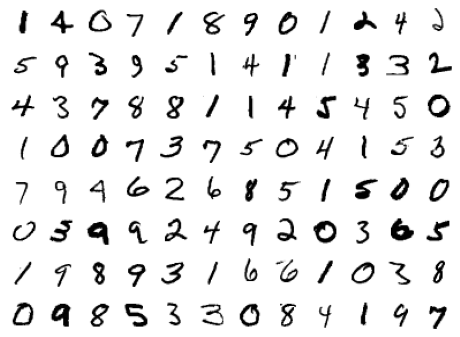

In [4]:
figure = plt.figure(figsize=(8,6))
dataiter = iter(train_loader)
images, labels = dataiter.next()
num_of_images = 96
for index in range(1, num_of_images + 1):
    plt.subplot(8, 12, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 26    RF:  2

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  
            nn.ReLU(),
        ) # output_size = 24 RF: 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12    RF:  6

        # TRANSITION BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 12    RF:  6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  10
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 8    RF: 14
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 6    RF: 18
            nn.ReLU(),
        )
         
        # Global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)  # output_size = 1    RF:  28
        )

        # Fully connected
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # output_size = 1    RF: 28
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # output  RF: 28
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.convblock3(x)
        x = self.gap(x)
        x = self.convblock5(x)
        x = x.view(-1, 10)   # convert 2D to 1D
        
        return F.log_softmax(x, dim=-1)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]             864
              ReLU-9           [-1, 12, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           1,728
             ReLU-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 20, 6, 6]           2,880
             ReLU-13             [-1, 20, 6, 6]               0
        AvgPool2d-14             [

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={loss.item():.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
NUM_EPOCHS = 15
for epoch in range(1,NUM_EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3012, Accuracy: 1035/10000 (10.35%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4151, Accuracy: 8654/10000 (86.54%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1719, Accuracy: 9473/10000 (94.73%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0965, Accuracy: 9690/10000 (96.90%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9684/10000 (96.84%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9772/10000 (97.72%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9804/10000 (98.04%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9796/10000 (97.96%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0709, Accuracy: 9788/10000 (97.88%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9821/10000 (98.21%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9824/10000 (98.24%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9834/10000 (98.34%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9866/10000 (98.66%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9850/10000 (98.50%)

EPOCH: 15


Batch_id=468 Loss=0.07951 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.0464, Accuracy: 9862/10000 (98.62%)



Text(0.5, 1.0, 'Test Accuracy')

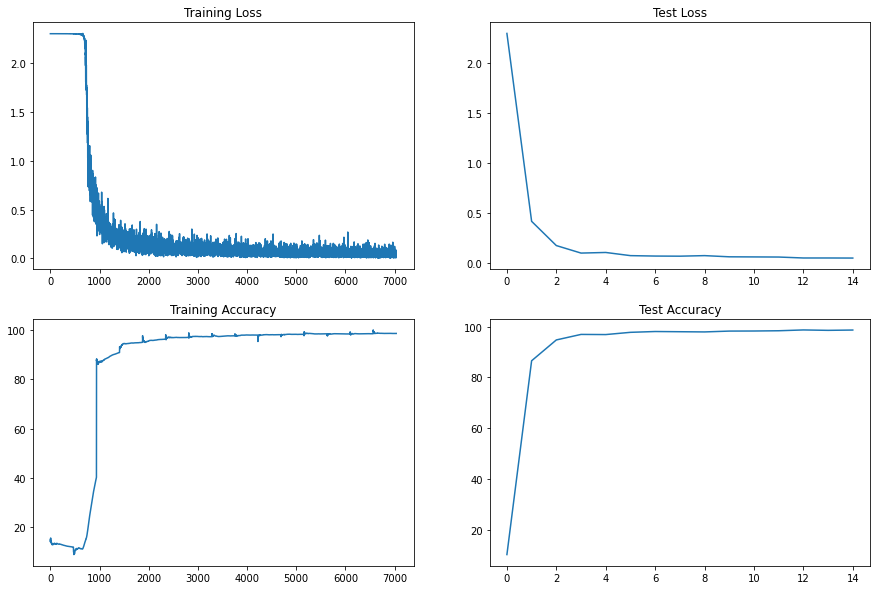

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [10]:
""

''